# **Imports**

In [1]:
import pandas as pd
from sklearn import datasets
import numpy as np
import math
import matplotlib.pyplot as plt
from K_means import *
from sklearn.datasets import make_blobs
from numpy import dot
from numpy.linalg import norm
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler, normalize
from scipy.sparse.linalg import eigs, eigsh
from spectral_clustering import *
from scipy.spatial.distance import cdist
from spectral_fonctions import *

# **Data manipulation**

## Iris Dataset

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

sc = StandardScaler()
sc.fit(X)
X_std= sc.transform(X)

df = pd.DataFrame(X_std)
df['True_Label'] = y

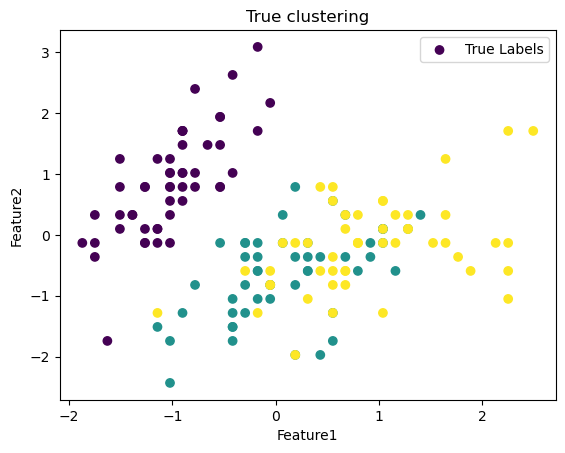

In [3]:
# visualize true clustering (we project on the first two dimensions)
plt.scatter(df[0], df[1], c=df['True_Label'], cmap='viridis', label='True Labels')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('True clustering')
plt.legend()
plt.show()

## Blob Dataset 

In [4]:
# generate synthetic data

# parameters
n_samples = 300
n_features = 15
n_clusters = 4

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)

sc = StandardScaler()
sc.fit(X)
X_std= sc.transform(X)

df = pd.DataFrame(X_std)
df['True_Label'] = y

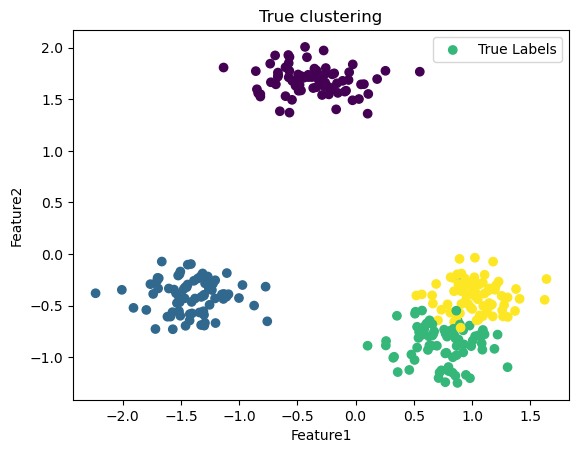

In [5]:
# visualize true clustering (we project on the first two dimensions)
plt.scatter(df[0], df[1], c=df['True_Label'], cmap='viridis', label='True Labels')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('True clustering')
plt.legend()
plt.show()

# **Spectral functions**

## Similarity measures

In [6]:
def gaussian_similarity_function(data_point_1, data_point_2) : 
    sigma = 1
    dist = np.linalg.norm(data_point_1 - data_point_2)
    return np.exp( - ((dist**2) / (2*sigma)))
def euclidian_similarity_function(data_point_1, data_point_2) :
    return np.linalg.norm(data_point_1 - data_point_2)

## Adjacency matrices

In [7]:
def fully_connected_adjacency_matrix(data, similarity_funtion) : 
    (nbr_of_points, dimension) = np.shape(data)
    W = np.zeros((nbr_of_points,nbr_of_points))
    for i in range(nbr_of_points) :
        for j in range(i+1, nbr_of_points) :
            W[i, j] = similarity_funtion(data[i], data[j])
    W = W + W.T
    for i in range(nbr_of_points) :
        W[i,i] = similarity_funtion(data[i], data[i])
    # Not sure if we need to do it. 
    return W

In [8]:
def KNN_adjacency_matrix(data, similarity_function, K, weighted : bool) :
    (nbr_of_points, dimension) = np.shape(data)
    W = np.zeros((nbr_of_points,nbr_of_points))
    for i in range(nbr_of_points) :
        distances = {}
        for j in range(nbr_of_points) :
            if j != i :
                distances[j] = euclidian_similarity_function(data[i], data[j])
            if j == i :
                distances[j] = np.inf
        sorted_distances = dict(sorted(distances.items(), key=lambda item: item[1], reverse=False))
        keys_to_zero = list(sorted_distances.keys())[K:]
        keys_to_one = list(sorted_distances.keys())[:K]
        for key in keys_to_zero :
            distances[key] = 0
        if weighted :
            for key in keys_to_one :
                distances[key] = similarity_function(data[i], data[key]) #for weighted graph
        else :
            for key in keys_to_one :
                distances[key] = 1
        W[i] = list(distances.values())
    return 0.5 * (W + W.T)

## Laplacians

In [9]:
def degree_matrix(adjacency_matrix) :
    dimension = len(adjacency_matrix)
    d = []
    for i in range(dimension) :
        d.append(sum(adjacency_matrix[i]))
    D = np.diag(d)
    return D

In [10]:
def regular_laplacian(adjacency_matrix) :

    W = adjacency_matrix
    D = degree_matrix(W)

    return D - W

In [11]:
def laplacian_sym(adjacency_matrix) :

    W = adjacency_matrix
    I = np.identity(len(W))

    dimension = len(W)
    d = []
    for i in range(dimension) :
        d.append(1/(math.sqrt(sum(adjacency_matrix[i]))))

    D_minus_one_half = np.diag(d)

    step_1 = np.matmul(W, D_minus_one_half)
    step_2 = np.matmul(D_minus_one_half, step_1)

    return I - step_2


In [12]:
def laplacian_rw(adjacency_matrix) : 

    W = adjacency_matrix
    I = np.identity(len(W))

    dimension = len(W)
    d = []
    for i in range(dimension) :
        d.append(1/(sum(adjacency_matrix[i])))

    D_minus_1 = np.diag(d)

    return I - np.matmul(D_minus_1, W)

## Eigenvectors computation

In [13]:
def power_iteration(A, n_simulations):

    vector = np.random.rand(A.shape[1])

    for i in range(n_simulations):
        y = np.dot(A, vector)
        new_vector = y / np.linalg.norm(y)
        if np.linalg.norm(new_vector - vector) < 1e-6:
            break
        vector = new_vector

    lambda_k = np.dot(new_vector, np.dot(A, new_vector)) / np.dot(new_vector, new_vector)

    return new_vector, lambda_k

In [14]:
def simultaneous_power_iteration(A):

    # QR method

    n, m = A.shape
    Q = np.random.rand(n, n)
    Q, _ = np.linalg.qr(Q)
    Q_prev = Q
 
    for i in range(1000):
        Z = A.dot(Q)
        Q, R = np.linalg.qr(Z)

        err = ((Q - Q_prev) ** 2).sum()

        Q_prev = Q
        if err < 1e-6:
            break

    return np.diag(R), Q

In [15]:
def compute_matrix_U_simult_power(A, k) :

    Q = simultaneous_power_iteration(A)[1]
    U = Q[:, -k:] 

    return U

In [16]:
def compute_matrix_U_ARPACK(A, k) :

    vecp = eigsh(A, k, which='SM')[1]
    
    return vecp

## Final spectral clustering functions

In [17]:
def final_spectral_clustering_regular(data, similarity_function, k_nearest_neighboors, number_of_clusters, weighted : bool, eigensolver) :

    W = KNN_adjacency_matrix(data, similarity_function, k_nearest_neighboors, weighted)
    L = regular_laplacian(W)
    U = eigensolver(L, number_of_clusters)

    kmeans = generalized_Kmeans(k=number_of_clusters, init='forgy', epochs=10, random_seed=42)
    kmeans.fit(U)

    return kmeans.predict(U)

In [18]:
def final_spectral_clustering_sym(data, similarity_function, k_nearest_neighboors, number_of_clusters, weighted : bool, eigensolver) :

    W = KNN_adjacency_matrix(data, similarity_function, k_nearest_neighboors, weighted)
    L = laplacian_sym(W)
    U = eigensolver(L, number_of_clusters)
    T = normalize(U, norm="l2")

    kmeans = generalized_Kmeans(k=number_of_clusters, init='forgy', epochs=10, random_seed=42)
    kmeans.fit(T)

    return kmeans.predict(T)

In [19]:
def final_spectral_clustering_rw(data, similarity_function, k_nearest_neighboors, number_of_clusters, weighted : bool, eigensolver) :

    W = KNN_adjacency_matrix(data, similarity_function, k_nearest_neighboors, weighted)
    L = laplacian_rw(W)
    U = eigensolver(L, number_of_clusters)

    kmeans = generalized_Kmeans(k=number_of_clusters, init='forgy', epochs=10, random_seed=42)
    kmeans.fit(U)

    return kmeans.predict(U)

# **Measures**

## Final function

In [22]:
labels = final_spectral_clustering_sym(X_std, gaussian_similarity_function, k_nearest_neighboors= 5, number_of_clusters= 4, weighted=True, eigensolver= compute_matrix_U_ARPACK)

In [6]:
df['Predicted_Label'] = labels

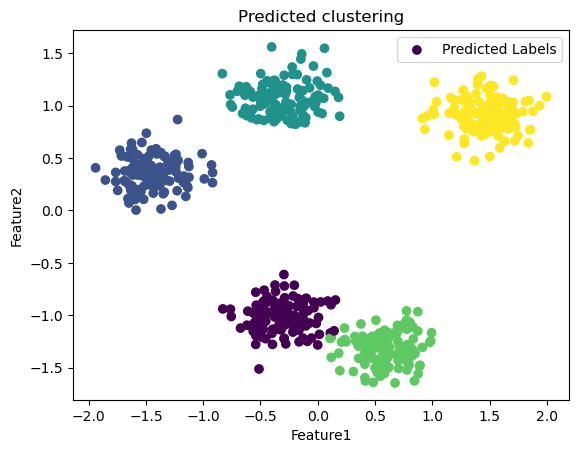

In [7]:
# predicted clustering visualization
plt.scatter(df[0], df[1], c=df['Predicted_Label'], cmap='viridis', label='Predicted Labels')
#plt.scatter(kmeans.centers_[:, 0], kmeans.centers_[:, 1], marker='x', s=200, c='red', label='Centroids')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Predicted clustering')
plt.legend()
plt.show()

## Little test of the class on the blobs

In [8]:
spc = spectral_clustering(gaussian_similarity_function_, 5, 5, 'k_nearest_neighbors', True, 'sym', compute_matrix_U_ARPACK)

In [10]:
df['Predicted_Label'] = spc.fit_predict(X_std).labels

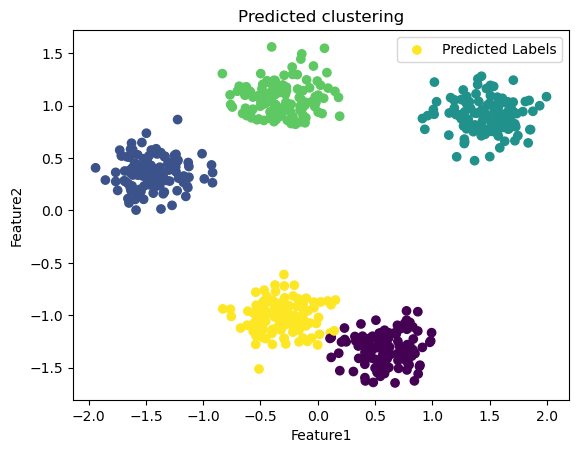

In [11]:
plt.scatter(df[0], df[1], c=df['Predicted_Label'], cmap='viridis', label='Predicted Labels')
#plt.scatter(kmeans.centers_[:, 0], kmeans.centers_[:, 1], marker='x', s=200, c='red', label='Centroids')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Predicted clustering')
plt.legend()
plt.show()